In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
import pickle, time, os

In [2]:
a1 = np.array([3, np.sqrt(3)])/2
a2 = np.array([3, -np.sqrt(3)])/2

d1 = np.array([1, 0])

In [3]:
def generate_supercell_vectors(Lx, Ly):
    R_vec = np.zeros(shape=(2*Lx*Ly, 2))
    for i in range(Lx):
        for j in range(Ly):
            R_vec[2*(i+Lx*j), :] = i*a1+j*a2
            R_vec[2*(i+Lx*j)+1, :] = i*a1+j*a2 +d1
            
    return R_vec

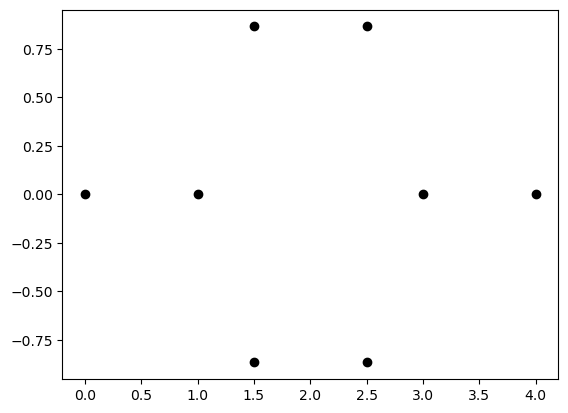

In [4]:
Lx, Ly = 2, 2

R_list = generate_supercell_vectors(Lx,Ly)
for i in range(2*Ly*Lx):
    plt.scatter(R_list[i, 0], R_list[i, 1], c='k')

In [5]:
Lx = 2
Ly = 2
R_list = generate_supercell_vectors(Lx,Ly)

A1 = Lx*a1
A2 = Ly*a2

# ----- helper: build the reciprocal lattice -----
def reciprocal_vectors(a1, a2):
    """Return b1, b2 for 2-D lattice defined by a1, a2."""
    area = a1[0]*a2[1] - a1[1]*a2[0]          # scalar 2-D cross product
    b1 = 2*np.pi*np.array([ a2[1], -a2[0]])/area
    b2 = 2*np.pi*np.array([-a1[1],  a1[0]])/area
    return b1, b2

b1, b2 = reciprocal_vectors(A1, A2)

def get_NN_BZ_pts(R1, R2):
    out_list = []
    for i in [0, 1, -1]:
        for j in [0, 1, -1]:
            out_list.append(R2-R1+i*A1+j*A2)
    return out_list
      
def get_BZ_points(k_num):
    k_pts_list = []
    for i in range(k_num):
        for j in range(k_num):
            k_pts_list.append(b1*i/k_num + b2*j/k_num)
            
    return k_pts_list

def get_BZ_grid(k_num):
    BZ_grid = np.zeros(shape=(k_num, k_num, 2))
    for i in range(k_num):
        for j in range(k_num):
            BZ_grid[i, j, :] = (b1*i/k_num + b2*j/k_num)
    return BZ_grid

In [6]:
def H_supercell(k, t1, t2, phi_h):
    H = np.zeros(shape=(2*Lx*Ly, 2*Lx*Ly), dtype=np.complex64)
    for i in range(2*Lx*Ly):
        for j in range(2*Lx*Ly):
            R1 = R_list[i, :]
            R2 = R_list[j, :]
            
            neighbour_list = get_NN_BZ_pts(R1, R2)
            
            for pt in neighbour_list:
                if np.allclose(np.abs(pt@pt), 1):
                    H[i, j]+=-t1*np.exp(1j*np.dot(k, pt))
            for pt in neighbour_list:
                if np.allclose(np.abs(pt@pt), 3):
                    if np.any(np.all(pt == np.array([a1, -a2, a2-a1]), axis=1)):
                        H[i, j]+=-2*t2*np.exp(1j*np.dot(k, pt))*np.exp(1j*phi_h)*np.exp(1j*(i%2))
                    elif np.any(np.all(pt == -np.array([a1, -a2, a2-a1]), axis=1)):
                        H[i, j]+=-2*t2*np.exp(1j*np.dot(k, pt))*np.exp(-1j*phi_h)*np.exp(1j*(i%2))
    return H

In [7]:
t1 = 1
phi_h = 0#np.arccos(3*np.sqrt(3/43))
t2 = 0#t1/4/(3*np.sqrt(3/43))

k_num = 30
x = np.zeros(k_num**2)
y = np.zeros_like(x)
bands = np.zeros(shape=(k_num**2, 2*Lx*Ly))

for i, k in enumerate(get_BZ_points(k_num)):
    x[i], y[i] = k
    bands[i, :] = np.linalg.eigvalsh(H_supercell(k, t1, t2, phi_h))

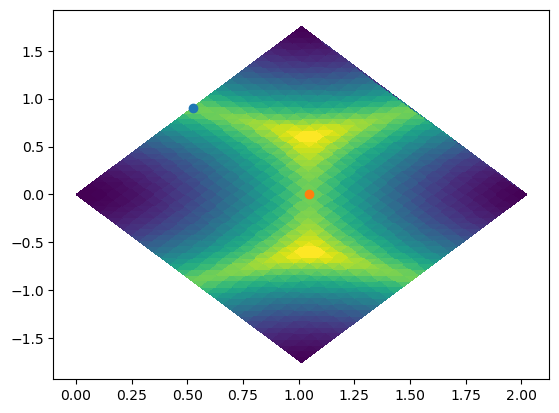

In [8]:
plt.tripcolor(x, y, bands[:, 0])
#plt.xlim(-np.pi/2, np.pi/2)
#plt.ylim(-np.pi/2, np.pi/2)
plt.scatter([b1[0]/2], [b1[1]/2])
K_n = (b1+b2)/2
plt.scatter([K_n[0]], [K_n[1]])

In [9]:
Γ = np.zeros(2)
K = np.array([1, 1/np.sqrt(3)])*2*np.pi/3/2         
M = 0.5*b1  

# path: Γ→K, K→M, M→Γ  (Nk points per segment)
def kpath(Nk_seg=60):
    seg1 = np.linspace(Γ, K, Nk_seg, endpoint=False)
    seg2 = np.linspace(K, M, Nk_seg, endpoint=False)
    seg3 = np.linspace(M, Γ, Nk_seg, endpoint=True)
    return np.vstack([seg1, seg2, seg3])

K_new = (b1+b2)/2

def kpath_new(Nk_seg=60):
    seg1 = np.linspace(Γ, M, Nk_seg, endpoint=False)
    seg2 = np.linspace(M, K_new, Nk_seg, endpoint=False)
    seg3 = np.linspace(K_new, Γ, Nk_seg, endpoint=True)
    return np.vstack([seg1, seg2, seg3])

In [10]:

t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))

energies = np.zeros(shape=(60*3, 2*Lx*Ly))


for i, k in enumerate(kpath()):
    energies[i, :] = np.linalg.eigvalsh(H_supercell(k, t1, t2, phi_h))

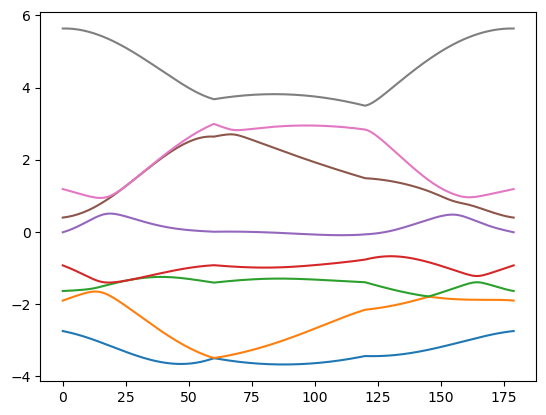

In [11]:
for i in range(2*Lx*Ly):
    plt.plot(energies[:, i])

In [12]:


os.environ["OMP_NUM_THREADS"] = "12"     # or the number of physical cores you have
os.environ["MKL_NUM_THREADS"] = "12"     # same variable if you use MKL


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 2*Lx*Ly  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [13]:
import itertools

def get_m_basis_indices(N, M):
    """
    Generate the indices of the M-particle sector in the full Hilbert space.
    
    Parameters:
    N (int): Number of orbitals.
    M (int): Number of particles.
    
    Returns:
    list: Sorted list of indices in the full Hilbert space.
    """
    total_modes = 2 * N
    m_indices = []
    for bits in itertools.combinations(range(total_modes), M):
        index = 0
        for q in bits:
            # Reverse mode order to match the Kronecker product ordering
            pos = total_modes - 1 - q
            index += (1 << pos)
        m_indices.append(index)
    return sorted(m_indices)

# Example usage:
#N = 4
M = N-4  # Choose your desired particle number sector

# Generate the indices for the M-particle sector
m_indices = get_m_basis_indices(N//2, M)

# Assuming H is your Hamiltonian constructed as a sparse matrix in the full space
# Project H into the M-particle sector
#H_m = H[m_indices, :][:, m_indices]

# Convert to a dense matrix if needed (be cautious with memory)
# H_m_dense = H_m.toarray()

In [14]:
def hamil(t1, mu, U, t2, phi_h, k):
    hamiltonian = sp.csr_matrix((2**N, 2**N), dtype=complex)
    NN_ham_mat = H_supercell(k, t1, t2, phi_h)
    for i in range(N):
        for j in range(i+1, N):
            if NN_ham_mat[i,j] ==0: continue
            hamiltonian+=cdags[i]@cs[j]*NN_ham_mat[i,j] + cdags[j]@cs[i]*NN_ham_mat[j, i]
            hamiltonian+=cdags[i]@cs[i]@cdags[j]@cs[j]*U/(Lx*Ly)
    for i in range(N):
        hamiltonian+=-(mu)*(cdags[i]@cs[i])
    
    return hamiltonian

def n_filled(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op@ evecs*np.exp(-beta*evals)).real.sum()/Z0

from scipy.special import logsumexp

def n_filled_stable(H_csr, beta, num_op):
    #evals, evecs = full_diag_dense(H_csr)
    evals, evecs = sp.linalg.eigsh(H_csr, k=6, which='SA')
    logw = -beta * evals                       # log-weights

    Ndiag = np.diag(evecs.T.conj() @ num_op @ evecs).real
    log_num = logsumexp(logw, b=Ndiag)         # log Σ e^{-βE_i} N_ii
    log_den = logsumexp(logw)                  # log Z

    return np.exp(log_num - log_den)


def n_filled2(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op2@ evecs*np.exp(-beta*evals)).real.sum()/Z0

def n_filled_tot(t1, mu, U, t2, phi_h, beta, k_num):
    acc = 0
    for k in get_BZ_points(k_num):
        hamil_k = hamil(t1, mu, U, t2, phi_h, k)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        acc+=n_filled_stable(hamil_k, beta, num_op)
    return acc/k_num/k_num

def compressibility(mu, t, U, beta, k_num):
    acc = 0
    for k in get_redBZ_points(k_num):
        hamil_k = hamil(t, mu, U, k, True)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        #acc+=n_filled2(H, beta) -n_filled(H, beta)**2
        acc+=n_filled_stable(hamil_k, beta, num_op2) - n_filled_stable(hamil_k, beta, num_op)**2
    return acc*beta/Lx/Ly/k_num/k_num

In [15]:
num_op = sp.csr_matrix((2**N, 2**N), dtype=complex)
for i in range(N):
    num_op+=cdags[i]@cs[i]

In [16]:
evals, evecs = sp.linalg.eigsh(num_op[m_indices, :][:, m_indices], k=6, which='SA')
evals

array([4., 4., 4., 4., 4., 4.])

In [17]:
t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))
k_num = 10

U_list = np.array([8])
beta_list = np.array([100])

filling_list = np.zeros(shape=(len(U_list), len(beta_list), 30))

for U_ind, U in enumerate(U_list):
    print(U)
    for beta_ind, beta in enumerate(beta_list):
        mu_list = np.linspace(0, 2.5, 30)
        for mu_ind, mu in enumerate(mu_list):
            filling_list[U_ind, beta_ind, mu_ind] = n_filled_tot(t1, mu, U, t2, phi_h, beta, k_num)
            print(mu_ind)

8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


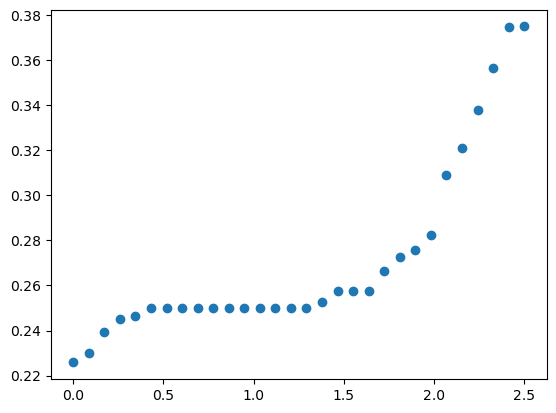

In [18]:
plt.scatter(mu_list, filling_list[0,0,:]/(2*Lx*Ly))
#plt.axhline(y=0.3333)

In [79]:
t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))
U = 0
beta = 100
mu = 0.7

N_eigs = 3

energies = np.zeros(shape=(60*3, N_eigs))

for i, k in enumerate(kpath()):
    hamil_k = hamil(t1, mu, U, t2, phi_h, k)
    evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
    energies[i, :] = np.sort(evals)

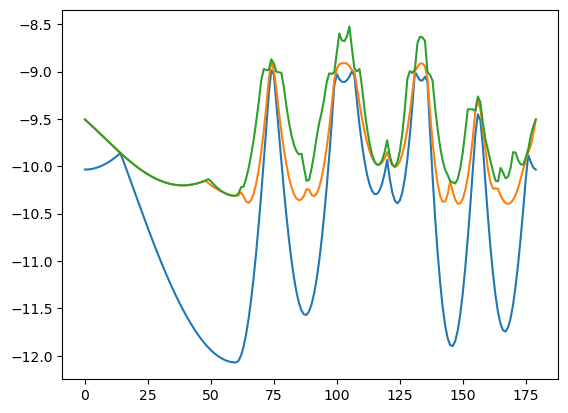

In [80]:
for i in range(N_eigs):
    plt.plot(energies[:, i])

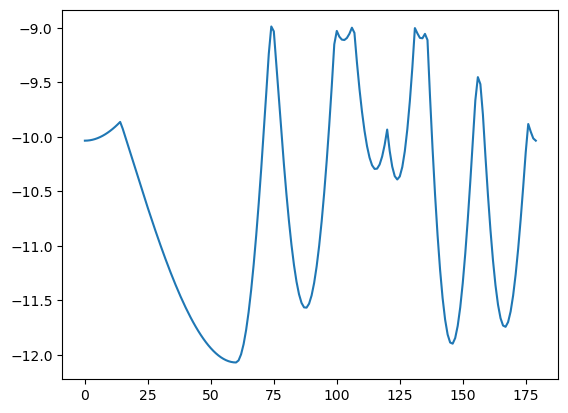

In [76]:
for i in range(N_eigs):
    plt.plot(energies[:, i])

-0.999999999999999


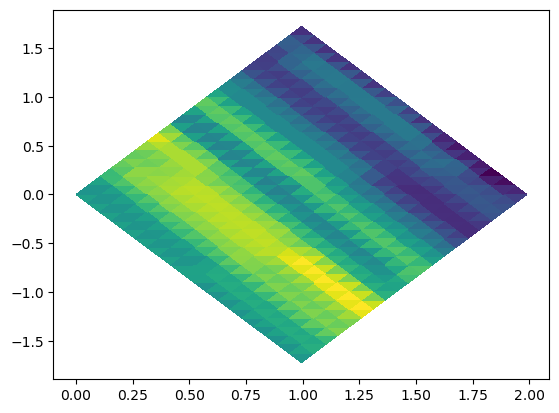

2.0


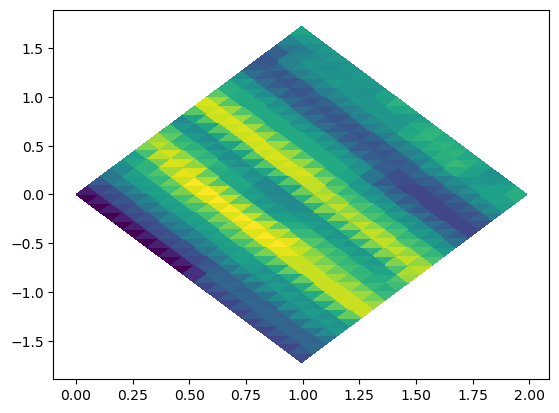

2.000000000000001


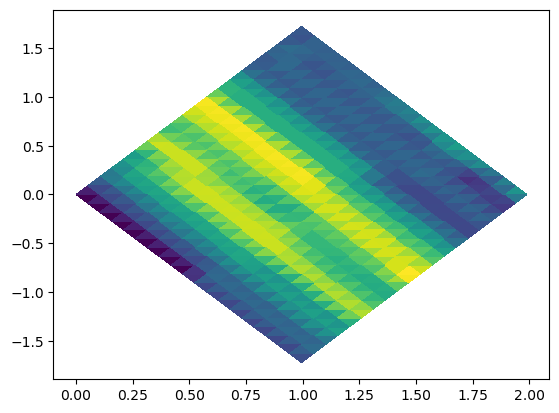

-2.8271597168564594e-16


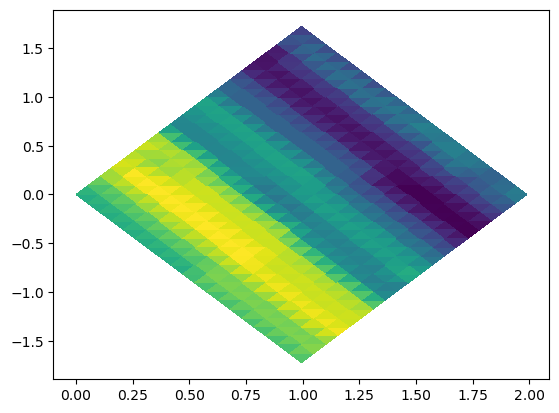

1.0000000000000002


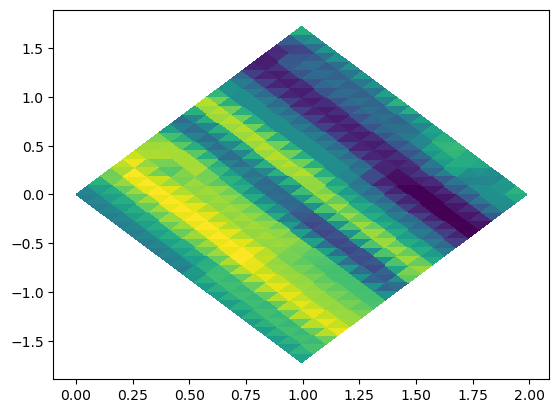

In [54]:
t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))
U = 8
mu = 0.8

k_num = 20

N_eigs = 1
gs_list = []

for _ in range(5):
    gs_evec_list = np.zeros(shape=(k_num,k_num, 2**(2*Lx*Ly)), dtype=complex)

    BZ_grid = get_BZ_grid(k_num)
    x, y = [], []
    
    for i in range(k_num):
        for j in range(k_num):
            k = BZ_grid[i, j, :]
            x.append(k[0])
            y.append(k[1])
            hamil_k = hamil(t1, mu, U, t2, phi_h, k)
            evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
            gs_evec_list[i, j, :] = evecs[:, 0]

    phase=0
    particle_number = 0
    
    
    phase_grid = []
    
    
    for i in range(k_num):
        for j in range(k_num):
            psi1 = gs_evec_list[i, j, :]
            psi2 = gs_evec_list[(i+1)%k_num, j, :]
            psi3 = gs_evec_list[i, (j+1)%k_num, :]
            psi4 = gs_evec_list[(i+1)%k_num, (j+1)%k_num, :]
            
            plaq_phase = np.angle(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1))
            phase += plaq_phase
            particle_number+=np.vdot(psi1, num_op@psi1)
            
            phase_grid.append(phase)
    print(phase/2/np.pi)
    gs_list.append(psi1)
    plt.tripcolor(x, y, phase_grid)
    plt.show()

In [56]:
np.vdot(gs_list[1], gs_list[2])

(-0.8401104209911786-0.5424154132600068j)

In [25]:
phase/2/np.pi

-1.0000000000000007

In [26]:
particle_number/k_num**2

(5.3275+1.0661974284004303e-18j)

In [34]:
t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))
U = 8
mu = 0.8

k_num = 20

N_eigs = 1

for p_num in range(1, 2*Lx*Ly):
    M = N-p_num
    m_indices = get_m_basis_indices(N//2, M)
    
    gs_evec_list = np.zeros(shape=(k_num,k_num, len(m_indices)), dtype=complex)
    
    for i in range(k_num):
        for j in range(k_num):
            k = BZ_grid[i, j, :]
            hamil_k = hamil(t1, mu, U, t2, phi_h, k)[m_indices, :][:, m_indices]
            evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
            gs_evec_list[i, j, :] = evecs[:, 0]
    
    
    phase=0
    particle_number = 0
    
    
    for i in range(k_num):
        for j in range(k_num):
            psi1 = gs_evec_list[i, j, :]
            psi2 = gs_evec_list[(i+1)%k_num, j, :]
            psi3 = gs_evec_list[i, (j+1)%k_num, :]
            psi4 = gs_evec_list[(i+1)%k_num, (j+1)%k_num, :]

            phase += np.angle(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1))

            particle_number+=np.vdot(psi1, num_op[m_indices, :][:, m_indices]@psi1)
            
    print(p_num, phase/2/np.pi, (particle_number/k_num**2).real)

1 2.0 (1+0j)
2 -1.999999999999999 (2+0j)
3 -3.9999999999999987 (3-8.313406031152304e-19j)
4 -1.0000000000000016 (4+0j)
5 -3.9999999999999987 (5+1.1688926955422767e-18j)
6 4.000000000000002 (6-1.0987711391782784e-18j)
7 -0.9999999999999996 (7+1.113272343235272e-18j)


In [35]:
t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))
U = 8
mu = 0.8

k_num = 20

N_eigs = 1

for p_num in range(1, 2*Lx*Ly):
    M = N-p_num
    m_indices = get_m_basis_indices(N//2, M)
    
    gs_evec_list = np.zeros(shape=(k_num,k_num, len(m_indices)), dtype=complex)
    
    for i in range(k_num):
        for j in range(k_num):
            k = BZ_grid[i, j, :]
            hamil_k = hamil(t1, mu, U, t2, phi_h, k)[m_indices, :][:, m_indices]
            evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
            gs_evec_list[i, j, :] = evecs[:, 0]
    
    
    phase=0
    particle_number = 0
    
    
    for i in range(k_num):
        for j in range(k_num):
            psi1 = gs_evec_list[i, j, :]
            psi2 = gs_evec_list[(i+1)%k_num, j, :]
            psi3 = gs_evec_list[i, (j+1)%k_num, :]
            psi4 = gs_evec_list[(i+1)%k_num, (j+1)%k_num, :]

            phase += np.angle(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1))

            particle_number+=np.vdot(psi1, num_op[m_indices, :][:, m_indices]@psi1)
            
    print(p_num, phase/2/np.pi, (particle_number/k_num**2).real)

1 2.0000000000000018 1.0
2 -1.0000000000000007 2.0
3 -1.9999999999999958 3.0
4 -0.9999999999999989 4.0
5 -0.9999999999999988 5.0
6 2.0000000000000013 6.0
7 -3.0 7.0
